# Frequentist Inference Case Study - Part B

## Learning objectives

Welcome to Part B of the Frequentist inference case study! The purpose of this case study is to help you apply the concepts associated with Frequentist inference in Python. In particular, you'll practice writing Python code to apply the following statistical concepts: 
* the _z_-statistic
* the _t_-statistic
* the difference and relationship between the two
* the Central Limit Theorem, including its assumptions and consequences
* how to estimate the population mean and standard deviation from a sample
* the concept of a sampling distribution of a test statistic, particularly for the mean
* how to combine these concepts to calculate a confidence interval

In the previous notebook, we used only data from a known normal distribution. **You'll now tackle real data, rather than simulated data, and answer some relevant real-world business problems using the data.**

## Hospital medical charges

Imagine that a hospital has hired you as their data scientist. An administrator is working on the hospital's business operations plan and needs you to help them answer some business questions. 

In this assignment notebook, you're going to use frequentist statistical inference on a data sample to answer the questions:
* has the hospital's revenue stream fallen below a key threshold?
* are patients with insurance really charged different amounts than those without?

Answering that last question with a frequentist approach makes some assumptions, and requires some knowledge, about the two groups.

We are going to use some data on medical charges obtained from [Kaggle](https://www.kaggle.com/easonlai/sample-insurance-claim-prediction-dataset). 

For the purposes of this exercise, assume the observations are the result of random sampling from our single hospital. Recall that in the previous assignment, we introduced the Central Limit Theorem (CLT), and its consequence that the distributions of sample statistics approach a normal distribution as $n$ increases. The amazing thing about this is that it applies to the sampling distributions of statistics that have been calculated from even highly non-normal distributions of data! Recall, also, that hypothesis testing is very much based on making inferences about such sample statistics. You're going to rely heavily on the CLT to apply frequentist (parametric) tests to answer the questions in this notebook.

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import scipy.stats
from numpy.random import seed
medical = pd.read_csv('insurance2.csv')

In [2]:
medical.shape

(1338, 8)

In [3]:
medical.head()

,age,sex,bmi,children,smoker,region,charges,insuranceclaim
0,19,0,27.900,0,1,3,16884.92400,1
1,18,1,33.770,1,0,2,1725.55230,1
2,28,1,33.000,3,0,2,4449.46200,0
3,33,1,22.705,0,0,1,21984.47061,0
4,32,1,28.880,0,0,1,3866.85520,1


__Q1:__ Plot the histogram of charges and calculate the mean and standard deviation. Comment on the appropriateness of these statistics for the data.

__A:__ The most frequent charges are around 10,000 dollars, however, some charges are has high as 60,000 dollars. The distribution of the charges is not a normal distribution which means that the mean is not located in the area where the most charges are because it is pulled to the right by the high charges. Because of this we will need to create a distribution of bootstrapped means to generate a normal distribution of the probable range of means. 

In [4]:
mean,std = np.mean(medical['charges']), np.std(medical['charges'], ddof = 1)
print(mean,std)

13270.422265141257 12110.011236694001


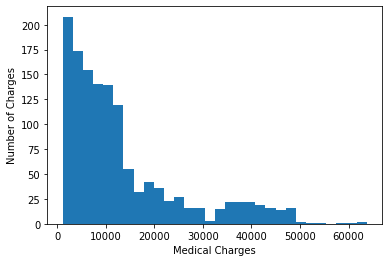

In [5]:
_ = plt.hist(medical['charges'], bins = 30)
_ = plt.xlabel('Medical Charges')
_ = plt.ylabel('Number of Charges')
#_ = plt.axvline(plt.axvline(x = mean, color='r'))
#_ = plt.axvline(plt.axvline(mean-12105, color='r', linestyle= '--'))
#_ = plt.axvline(plt.axvline(mean+12105, color='r', linestyle= '--'))
plt.show()

In [6]:
#The above distribution is not normal. So we need to take a non-parameteric approach with bootstrapping
bootstrap = pd.DataFrame({'mean_charge': [medical.sample(1338, replace = True).charges.mean() for i in range(1000)]})

__Q2:__ The administrator is concerned that the actual average charge has fallen below 12,000, threatening the hospital's operational model. On the assumption that these data represent a random sample of charges, how would you justify that these data allow you to answer that question? And what would be the most appropriate frequentist test, of the ones discussed so far, to apply?

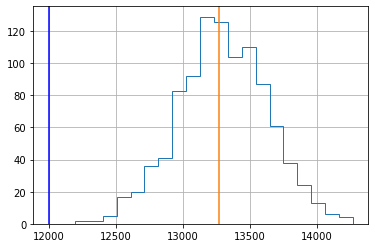

In [19]:
bootstrap.mean_charge.hist(histtype= 'step', bins = 20)
plt.axvline(medical.charges.mean(), color= 'C1') # this is the observed sample mean
plt.axvline(12000, color= 'blue') # this is the line for the mean charge that the hospital is worried about

In [12]:
b_mean, b_std = bootstrap.mean_charge.mean(), np.std(bootstrap.mean_charge)
print(b_mean, b_std)

13295.85821286883 332.4345477615939


In [21]:
#The 95% confidence interval for the mean is:
bootstrap.mean_charge.quantile(0.025), bootstrap.mean_charge.quantile(0.975)

(12603.55482249832, 13923.355444568926)

In [18]:
# On the z-table this is p = 0.00005 
z_score= (12000-b_mean)/(b_std)
print(z_score)

-3.8980852669926405


In [32]:
#12,000 falls in the 0 percentile
scipy.stats.percentileofscore(bootstrap.mean_charge,12000)

0.0

In [40]:
# there are no means in our bootstrap distribution that are less than 12000
bootstrap[bootstrap['mean_charge'] <= 12000].count()

mean_charge    0
dtype: int64

In [39]:
#the minimum mean charge in our bootstrap distribution is 12,196
bootstrap.mean_charge.min()

12196.728750064276

__A:__ If the mean charge has fallen to 12000 dollars it is outside of the range of most probable means (2 sided 95% CI 12603.56 to 13843.98). There is only a 0.0025% (p = 0.000025) chance of this being a random low mean. It is likely that something about the distribution of charges has changed to generate a mean this low. 

__Q3:__ Given the nature of the administrator's concern, what is the appropriate confidence interval in this case? A ***one-sided*** or ***two-sided*** interval? (Refresh your understanding of this concept on p. 399 of the *AoS*). Calculate the critical value and the relevant 95% confidence interval for the mean, and comment on whether the administrator should be concerned.

In [29]:
# what value marks the beginning of the lower 5%
critical_value = bootstrap.mean_charge.quantile(0.05)
print(critical_value)

12726.507508095256


__A:__ A mean of 12,726.5 or less is outside of the one-sided 95% confidence interval. 

The administrator then wants to know whether people with insurance really are charged a different amount to those without.

__Q4:__ State the null and alternative hypothesis here. Use the _t_-test for the difference between means, where the pooled standard deviation of the two groups is given by:
\begin{equation}
s_p = \sqrt{\frac{(n_0 - 1)s^2_0 + (n_1 - 1)s^2_1}{n_0 + n_1 - 2}}
\end{equation}

and the *t*-test statistic is then given by:

\begin{equation}
t = \frac{\bar{x}_0 - \bar{x}_1}{s_p \sqrt{1/n_0 + 1/n_1}}.
\end{equation}

(If you need some reminding of the general definition of ***t-statistic***, check out the definition on p. 404 of *AoS*). 

What assumption about the variances of the two groups are we making here?

__A:__ Null hypothesis: charge w/insurance = charge no insurance. Alternative hypothesis: charge w/insurance != charge no insurance. 

The assumptions are that the two groups are normally distributed and and independent. 

__Q5:__ Perform this hypothesis test both manually, using the above formulae, and then using the appropriate function from [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html#statistical-tests) (hint, you're looking for a function to perform a _t_-test on two independent samples). For the manual approach, calculate the value of the test statistic and then its probability (the p-value). Verify you get the same results from both.

__A:__ 

In [8]:
medical.groupby('insuranceclaim').charges.mean()

insuranceclaim
0     8821.421892
1    16423.928277
Name: charges, dtype: float64

In [13]:
medical['insuranceclaim'].value_counts()

1    783
0    555
Name: insuranceclaim, dtype: int64

In [25]:
insurance = medical[medical['insuranceclaim'] == 1]['charges']
no_insurance = medical[medical['insuranceclaim'] == 0]['charges']

14036.956250260417 6440.699841605235


In [53]:
std_insurance, std_none = np.std(insurance, ddof = 1), np.std(no_insurance,ddof = 1)
count_insurance, count_none = insurance.count(), no_insurance.count()
mean_insurance, mean_none = np.mean(insurance), np.mean(no_insurance)


In [68]:
ttest_ind(insurance, no_insurance)

Ttest_indResult(statistic=11.893299030876712, pvalue=4.461230231620717e-31)

In [72]:
sp = np.sqrt((((count_insurance-1)*(std_insurance**2)) + ((count_none-1)*(std_none**2)))/(count_insurance + count_none - 2)) 
print(sp)

11520.034268775262


In [73]:
denom=  (sp * np.sqrt((1/count_insurance)+(1/count_none)))
print(denom)

639.2260351391296


In [74]:
t = (mean_insurance - mean_none)/denom
print(t)

11.89329903087671


P-value is <0.00001 that this extreme difference in means could have occurred by chance from a null distribution 

Congratulations! Hopefully you got the exact same numerical results. This shows that you correctly calculated the numbers by hand. Secondly, you used the correct function and saw that it's much easier to use. All you need to do is pass your data to it.

__Q6:__ Conceptual question: look through the documentation for statistical test functions in scipy.stats. You'll see the above _t_-test for a sample, but can you see an equivalent one for performing a *z*-test from a sample? Comment on your answer.

__A:__ A t-test is better here because we don't actually know the true population standard deviation. We can estimate using our samples but more data could 

## Learning outcomes

Having completed this project notebook, you now have good hands-on experience:
* using the central limit theorem to help you apply frequentist techniques to answer questions that pertain to very non-normally distributed data from the real world
* performing inference using such data to answer business questions
* forming a hypothesis and framing the null and alternative hypotheses
* testing this using a _t_-test